### Stock Price Prediction Model for CSE
Name - Don Lakshitha Udara
ID - S4114011
- Applying Classical and Neural network methods to identify a best fit model for Sri Lankan Stock exchange
- Please note that following tutorials were refered when building this models
#### LSTM from Tensorflow tutorials 
https://www.tensorflow.org/tutorials
#### ARIMA model from following tutorial
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


In [2]:
#Importing the libraries 
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import eikon as ek

In [3]:
#setting up some parameters 
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
RIC_LIST = ['.FTSE']
ek.set_app_key('#') #use your refinitiv key here 

2022-10-09 14:21:15,333 P[1644] [MainThread 10340] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-10-09 14:21:15,343 P[1644] [MainThread 10340] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-10-09 14:21:15,344 P[1644] [MainThread 10340] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-10-09 14:21:15,344 P[1644] [MainThread 10340] Port number was not identified, cannot send any request


In [4]:
# saving the Data in a file in case connectivity errors with refinitiv
if not os.path.isfile('./ftse_data_file.csv'):
 
    df = ek.get_timeseries(RIC_LIST,
                           start_date='2014-01-01',
                           end_date='2022-08-31',
                         interval='daily',)
    df.to_csv('./ftse_data_file.csv')
else:
    df = pd.read_csv('./ftse_data_file.csv',index_col='Date',parse_dates=True)

### Lets See How the data set Looks like


In [5]:
df.head()

,HIGH,CLOSE,LOW,OPEN,VOLUME
Date,,,,,
2014-01-02,6759.37,6717.91,6707.48,6749.09,459529089.0
2014-01-03,6747.33,6730.67,6699.27,6717.91,374841419.0
2014-01-06,6751.98,6730.73,6714.64,6730.67,524386927.0
2014-01-07,6768.89,6755.45,6718.07,6730.73,672375580.0
2014-01-08,6755.53,6721.78,6713.39,6755.45,720025203.0


<AxesSubplot:xlabel='Date'>

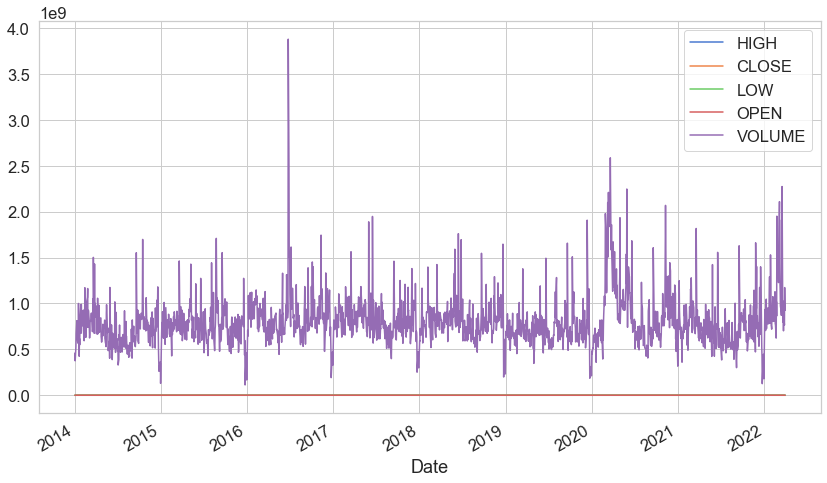

In [6]:
df.plot()

<AxesSubplot:ylabel='Density'>

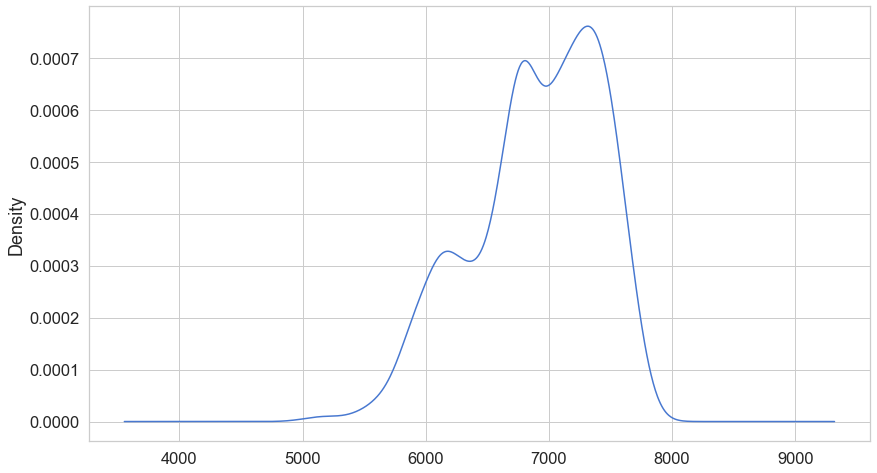

In [7]:
#Distribution of the dataset - picking the Close values only
 
df['CLOSE'].plot(kind='kde')

- Now that we have our Data set let's scale between 0-1 
- This is simply to shrink the data range into a small one

##### lets analise some seasonlity decompose features of the data set 

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

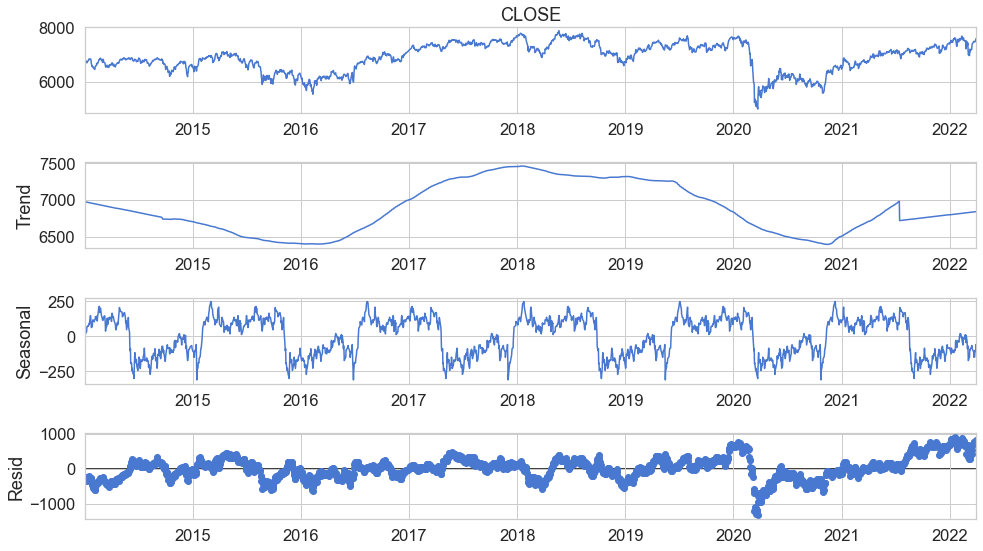

In [9]:
results = seasonal_decompose(x=df['CLOSE'],model='Addictive Decompose',extrapolate_trend='freq',period=365)
results.plot();

In [10]:
scaler = MinMaxScaler()
close_price = df.filter(['Date', 'CLOSE'])
scaler.fit(close_price)
scaled_close = scaler.transform(close_price)


In [11]:
#Taking only the close values
df = df['CLOSE'].values
df = df.reshape(-1, 1)
np.isnan(scaled_close).any() # checking nan values

False

In [12]:
#setting up the train and test data ( 80:20 split)
trainSet = np.array(df[:int(df.shape[0]*0.8)])
testSet = np.array(df[int(df.shape[0]*0.8):])

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
trainSet = scaler.fit_transform(trainSet)
testSet = scaler.transform(testSet)

#### LSTM model

In [16]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [17]:
xTrain, yTrain = create_dataset(trainSet)
xTest, yTest = create_dataset(testSet)


In [18]:
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

In [19]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [20]:
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')

-- note that in above I'm using adam as the optimizer 

Now we will train the model for 50 epochs with 32 batch size ... this may take some time ⌚
I suggest you to have a Coffee ☕break while this is running ! 

In [22]:
model.fit(xTrain, yTrain, epochs=50, batch_size=32)
model.save('cse_predict.cse')

Epoch 1/50
24/24 [==============================] - 9s 82ms/step - loss: 0.0254
Epoch 2/50
24/24 [==============================] - 2s 79ms/step - loss: 0.0066
Epoch 3/50
24/24 [==============================] - 2s 78ms/step - loss: 0.0078
Epoch 4/50
24/24 [==============================] - 2s 76ms/step - loss: 0.0057
Epoch 5/50
24/24 [==============================] - 2s 75ms/step - loss: 0.0043
Epoch 6/50
24/24 [==============================] - 2s 76ms/step - loss: 0.0041
Epoch 7/50
24/24 [==============================] - 2s 74ms/step - loss: 0.0035
Epoch 8/50
24/24 [==============================] - 2s 70ms/step - loss: 0.0040
Epoch 9/50
24/24 [==============================] - 2s 70ms/step - loss: 0.0038
Epoch 10/50
24/24 [==============================] - 2s 76ms/step - loss: 0.0029
Epoch 11/50
24/24 [==============================] - 2s 87ms/step - loss: 0.0032
Epoch 12/50
24/24 [==============================] - 2s 88ms/step - loss: 0.0028
Epoch 13/50
24/24 [==================

2022-04-19 14:02:07,545 P[26244] [MainThread 3560] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 8). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: cse_predict.cse\assets


2022-04-19 14:02:09,271 P[26244] [MainThread 3560] Assets written to: cse_predict.cse\assets
2022-04-19 14:02:09,616 P[26244] [MainThread 3560] <keras.layers.recurrent.LSTMCell object at 0x000001DF843F45E0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-04-19 14:02:09,616 P[26244] [MainThread 3560] <keras.layers.recurrent.LSTMCell object at 0x000001DF843902E0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-04-19 14:02:09,616 P[26244] [MainThread 3560] <keras.layers.recurrent.LSTMCell object at 0

In [23]:
#this may take a while as well - ⌚ 
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
model = load_model('cse_predict.cse')

In [24]:
predictionsLSTM = model.predict(xTest)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

-- Now lets Plot the results 

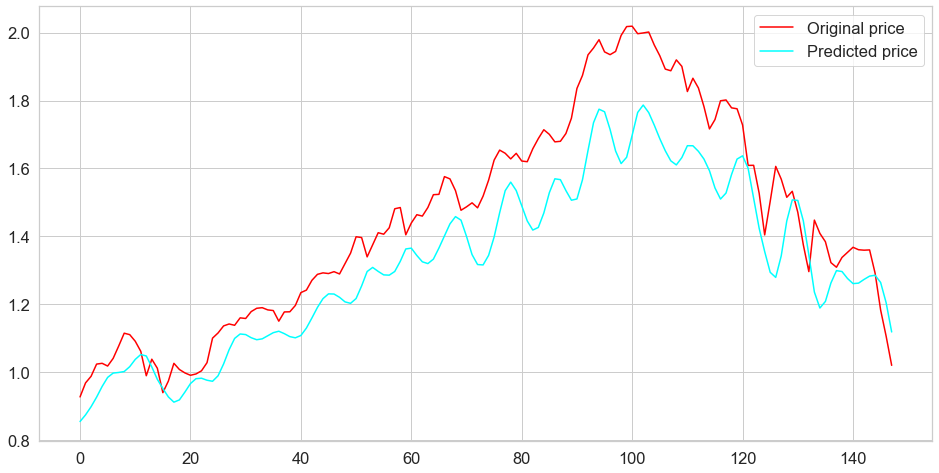

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTM, color='cyan', label='Predicted price')
plt.legend()

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [28]:
#creating a new dataframe and adding the LSTM predications and the original set
dtf = pd.DataFrame(y_test_scaled, columns=['Original'])
dtf['LSTM'] =  predictionsLSTM

### Now lets move to ES models 

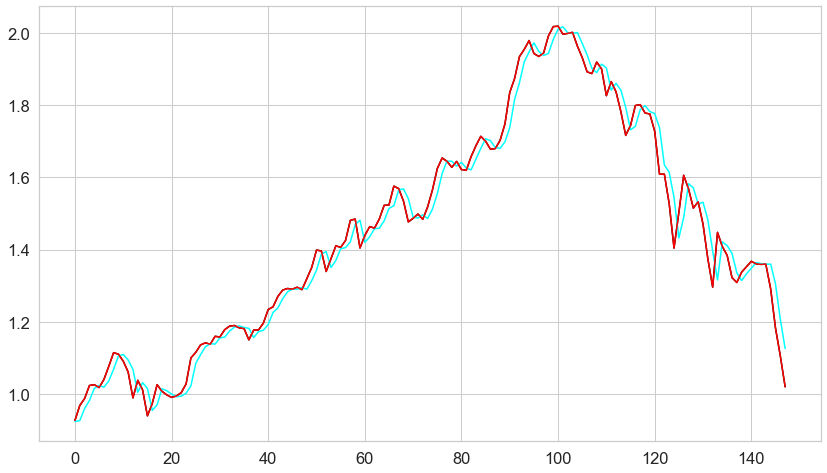

In [29]:
 
from statsmodels.tsa.api import SimpleExpSmoothing
data = y_test_scaled
fit_1 = SimpleExpSmoothing(data, initialization_method='heuristic').fit(smoothing_level=0.8,optimized=False)
fit_2 = SimpleExpSmoothing(data, initialization_method='heuristic').fit(smoothing_level=0.6,optimized=False)
forecast1 = data
plt.plot(data, color='black')
plt.plot(fit_1.fittedvalues, color='cyan')
line1, = plt.plot(forecast1, color='red')


# it's so simple isn't it , voila we got our plot ready 

In [30]:
#Adding these two predications to the same evaluation model
dtf['ES80'] =  fit_1.fittedvalues
dtf['ES60'] =  fit_2.fittedvalues #ES60

### Now lets Focus on ARIMA model

C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2087
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11715.096
Date:                Sun, 09 Oct 2022   AIC                          23442.192
Time:                        14:22:16   BIC                          23476.050
Sample:                             0   HQIC                         23454.598
                               - 2087                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0054      0.014     -0.384      0.701      -0.033       0.022
ar.L2         -0.0105      0.015     -0.685      0.494      -0.041       0.020
ar.L3          0.0074      0.011      0.666      0.5

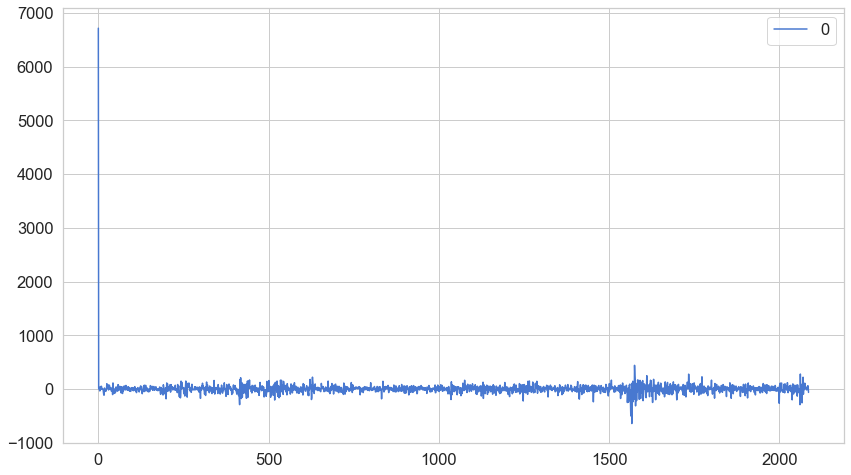

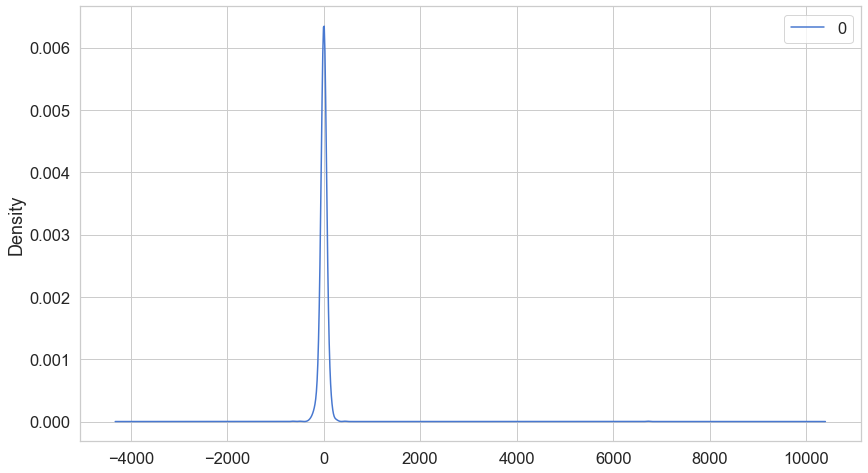

                 0
count  2087.000000
mean      3.609911
std     161.379424
min    -641.109629
25%     -31.619100
50%       3.665418
75%      35.502566
max    6717.910000


In [14]:
# fit an ARIMA model and plot residual errors
# got this ARIMA model from the following tutorial
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = df
 # fit model
modelArima = ARIMA(series, order=(5,1,0))
model_fit = modelArima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [16]:
series.shape

(2087, 1)

In [32]:
# I got this Arima model from following link and I slightly change it 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# evaluate an ARIMA model using a walk-forward validation
# This too may take a while to complete------ ⌚ take a break !!
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
 
# Remember we have to re scale the test series before applying it to ARIMA model  
train = scaler.inverse_transform(trainSet)    
test = scaler.inverse_transform(testSet)    
    
#train = trainSet
#test = testSet
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	modelArima = ARIMA(history, order=(5,1,0))
	model_fit = modelArima.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
 # evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))

# plot forecasts against actual outcomes


C:\Users\Udara\AppData\Local\Temp/ipykernel_26244/2445132587.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Udara\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: Convergen

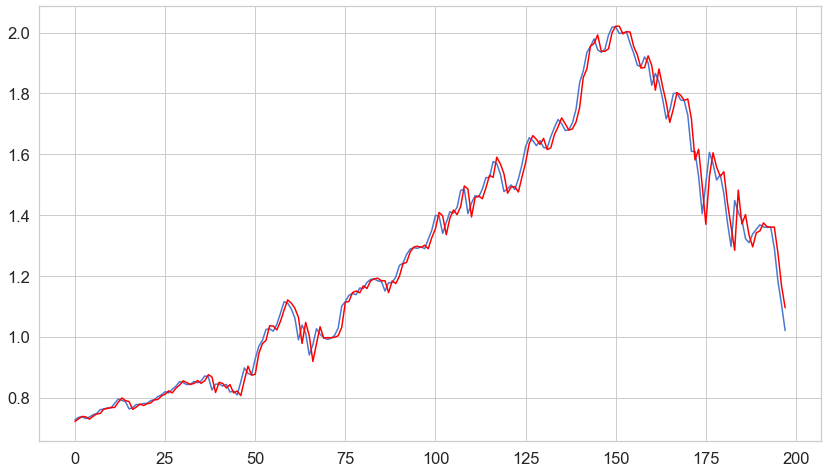

In [33]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show() 

-- well it will take some time , but it's done :) ..now we can plot the results !!!

In [34]:
arima =sqrt(mean_squared_error(test,predictions))
print(arima)

0.03706201583419013


we can't calculate the MSE value before transforming back the values , so see above value is not correct , we will get back to this later !!!

In [35]:
len(fit_2.fittedvalues)
predicationsArimaTrimmed = np.array(predictions[50:])

In [36]:
len(predicationsArimaTrimmed)
dtf['ARIMA'] =  predicationsArimaTrimmed # adding these values to our evaluating dataframe as well

In [37]:
dtf.head()
# now we have all !!

,Original,LSTM,ES80,ES60,ARIMA
0,0.927179,0.854669,0.924018,0.924018,0.876241
1,0.968436,0.874321,0.926547,0.925915,0.945099
2,0.987866,0.898246,0.960058,0.951427,0.976990
3,1.023817,0.926436,0.982304,0.973291,0.988065
4,1.026143,0.957864,1.015514,1.003606,1.035589


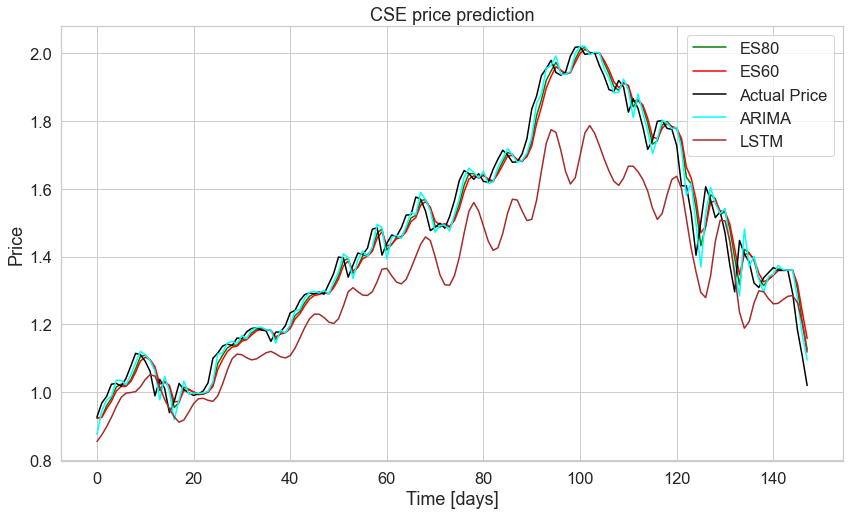

In [39]:
#lets plot all in one now
plt.plot(fit_1.fittedvalues, label = "ES80" ,color='Green') #.8
plt.plot(fit_2.fittedvalues, label = "ES60",color='Red') # .6 
plt.plot(dtf['Original'],label = "Actual Price", color='black') # actual
plt.plot(predicationsArimaTrimmed, label = "ARIMA",color='cyan')  # Arima
plt.plot(dtf['LSTM'],label = "LSTM",color='Brown') # LSTM

plt.title('CSE price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

## Suprisingly almost all the models did well in forecasting 

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
es80=sqrt(mean_squared_error(dtf['Original'],dtf['ES80']))
print(es80)
es60=sqrt(mean_squared_error(dtf['Original'],dtf['ES60']))
print(es60)
lstm=sqrt(mean_squared_error(dtf['Original'],dtf['LSTM']))
print(lstm)
arima =sqrt(mean_squared_error(dtf['Original'],dtf['ARIMA']))
print(arima)

 

0.04560012275084548
0.05046449129166548
0.1568365175006772
0.042033000573677606


Wow Arima & ES80 are so close !!!
Lets do a box plot to see how all of the modeled time series data looks like

<AxesSubplot:title={'center':'Predications summary values'}>

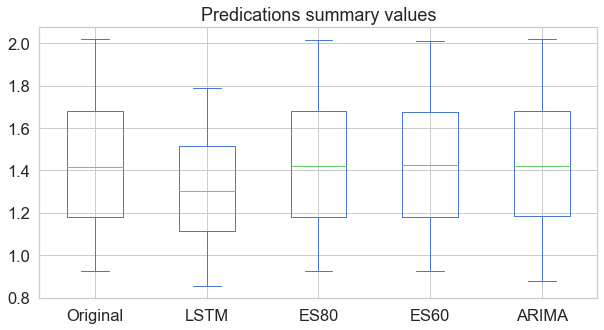

In [41]:
dtf.plot.box(figsize = (10,5), title = "Predications summary values") 

Now below is a bar chat to represent the MSE values , but values may seems different from the ones that we calculated ..but trust be propotionately it the same value !!! :)

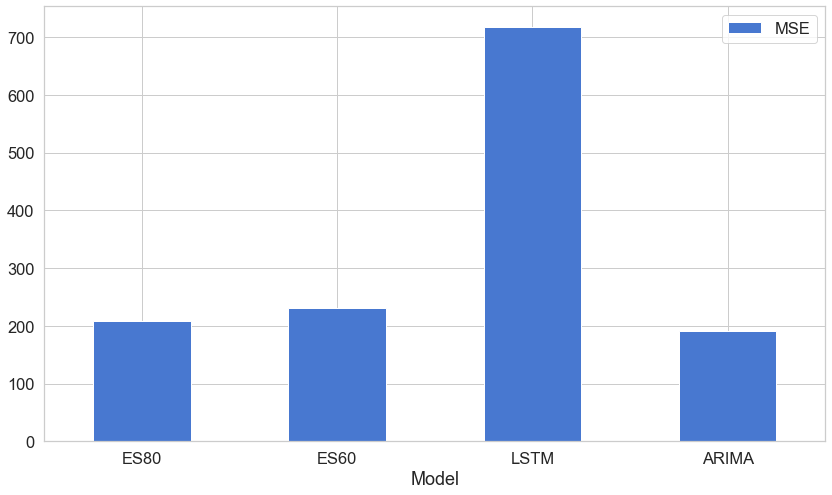

In [43]:
# Don't get me wron but these are not hard coded but values are not different it just that tranformation is not there 
df = pd.DataFrame({'Model':['ES80', 'ES60', 'LSTM','ARIMA'], 'MSE':[208.12169624222378, 230.32296612463875, 717.4241098734091,191.81600017915153
]})
ax = df.plot.bar(x='Model', y='MSE', rot=0)

#### Result 
- All the models did really well but there are two models which stand out from the rest,
- ARIMA & ES80 even from the box plot you can see both models were pretty similar to the Original plot
- In we can round up by saying ARIMA is the best fit model for CSE 
#### Future Work
- check how to fine tune LSTM model to compete with the Arima model
= Use this base forecasting methods to build a stock forecasting appliction for CSE
